In [10]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os, pickle
import sys
sys.path.append(".")
sys.path.append("../..")
import MinimaxParetoFair as MMPF

In [17]:
from scipy.stats import norm
def get_probabilities_extended(x_array, param_pa, param_pyxa, param_pxa):
    p_xa = np.zeros([x_array.shape[0], param_pa.shape[0]])
    p_yxa = np.zeros([x_array.shape[0], param_pa.shape[0]])

    for i in np.arange(param_pa.shape[0]):
        z_i = (x_array - param_pxa[i, 0]) / param_pxa[i, 1]
        p_xa[:, i] = norm.pdf(z_i)

        ## build p_yxa
        params = param_pyxa[i]
        th = params[0]
        values = params[1]
        aux = np.zeros([x_array.shape[0]])
        for j in np.arange(th.shape[0]):
            aux[x_array >= th[j]] += 1

        for j in np.arange(values.shape[0]):
            # print(values[j])
            p_yxa[aux == j, i] = values[j]
    return p_xa, p_yxa

def get_bs_optimal(x_array, p_xa, p_yxa, mua, type = 'MSE'):
    ##########################
    # THIS IS FOR BINARY Y!!!
    #########################

    dx = np.max(x_array) - np.min(x_array)
    dx /= x_array.shape[0]

    h = np.sum(p_yxa * p_xa * mua[np.newaxis, :], axis=1) / np.sum(p_xa * mua[np.newaxis, :], axis=1)

    if type == 'MSE':
        risk = p_yxa * 2 * ((1 - h[:, np.newaxis]) ** 2) + (1 - p_yxa) * 2 * ((h[:, np.newaxis]) ** 2)
        risk *= p_xa
        risk = np.sum(risk, axis=0) * dx
    else:
        risk = -p_yxa*np.log(h[:, np.newaxis]) - (1-p_yxa)*np.log((1-h[:, np.newaxis]))
        risk *=  p_xa
        risk = np.sum(risk, axis=0) * dx


    aux = (p_yxa - h[:, np.newaxis]) * p_xa / np.sum(p_xa * mua)
    aux2 = (p_yxa - h[:, np.newaxis])
    drisk = (-4 * aux[:, np.newaxis, :] * aux2[:, :, np.newaxis]) * p_xa[:, :,
                                                                    np.newaxis]  # -4 cause is binary so its X2
    drisk = np.sum(drisk, axis=0) * dx

    return h, risk, drisk

## Generate Distributions

In [18]:
param_pyxa = []
param_pyxa.append([-0.25,0,0.25])
param_pyxa.append([0.1,0.1,0.1])
param_pyxa.append([0.9,0.9,0.9])
param_pyxa = np.array(param_pyxa).transpose()

th = np.array([0])
param_pyxa_dic = {}
param = []
param.append(th-0.25)
param.append(np.array([0.9,0.1]))
param_pyxa_dic[0] = param
param = []
param.append(th)
param.append(np.array([0.9,0.1]))
param_pyxa_dic[1] = param
param = []
param.append(th+0.25)
param.append(np.array([0.8,0.2]))
param_pyxa_dic[2] = param

param_pxa = []
param_pxa.append([-0.5,0,0.5])
param_pxa.append([1,1,1])
param_pxa = np.array(param_pxa).transpose()

mu_a :  [0.33333333 0.33333333 0.33333333]
Risks :  [0.23611439 0.21096304 0.37159648]


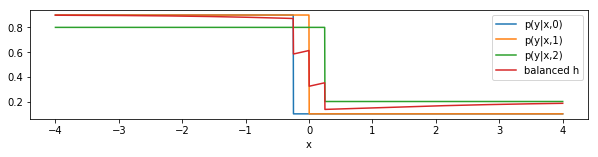

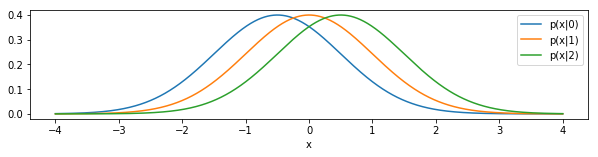

In [29]:
param_pa = np.array([1,1,1])/3

x_array = np.linspace(-4,4,2000)
dx = np.max(x_array)-np.min(x_array)
dx /= x_array.shape[0]
p_xa, p_yxa = get_probabilities_extended(x_array, param_pa, param_pyxa_dic, param_pxa)

mua = np.array([1,1,1])
mua = mua/np.sum(mua)
type_str = 'MSE'
h,risk,_ = get_bs_optimal(x_array,p_xa,p_yxa,mua,type=type_str)

print('mu_a : ',mua)
print('Risks : ', risk)

plt.figure(figsize=(10,2))
for i in np.arange(param_pa.shape[0]):
    plt.plot(x_array,p_yxa[:,i],label = 'p(y|x,'+str(i)+')')
plt.plot(x_array,h,label = 'balanced h')
plt.xlabel('x')
plt.legend()
plt.show()

plt.figure(figsize=(10,2))
for i in np.arange(param_pa.shape[0]):
    plt.plot(x_array,p_xa[:,i],label = 'p(x|'+str(i)+')')
plt.xlabel('x')
plt.legend()
plt.show()

In [58]:
#Greed search to find minmax risk (our objective)

n_mua = 500
# ix1 = np.linspace(0,1,n_mua)
# ix2 = np.linspace(0,1,n_mua)
ix1 = np.linspace(0.1,0.13,n_mua) #this intervals have been tunned to the parameters of this example
ix2 = np.linspace(0,0.1,n_mua)

mua_list = []

risk_best = np.ones([3])*np.inf
for i in ix1:
    for j in ix2:
        mua = np.array([i,j,1-i-j])
        h_aux,risk,_ = get_bs_optimal(x_array,p_xa,p_yxa,mua)
        if np.max(risk)<np.max(risk_best):
            risk_best = risk +0
            h_best = h_aux + 0
            mu_best = mua + 0

print(risk_best)
print(mu_best)

[0.3223688  0.27568202 0.32237722]
[1.14909820e-01 6.01202405e-04 8.84488978e-01]


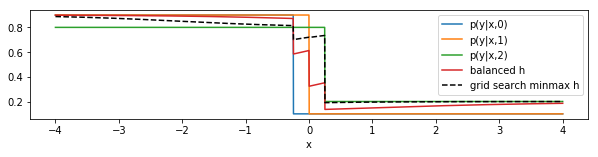

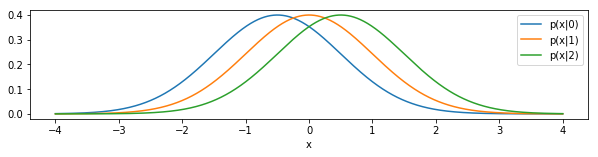

In [30]:
plt.figure(figsize=(10,2))
for i in np.arange(param_pa.shape[0]):
    plt.plot(x_array,p_yxa[:,i],label = 'p(y|x,'+str(i)+')')
plt.plot(x_array,h,label = 'balanced h')
plt.plot(x_array,h_best,'k--',label = 'grid search minmax h')
plt.xlabel('x')
plt.legend()
plt.show()

plt.figure(figsize=(10,2))
for i in np.arange(param_pa.shape[0]):
    plt.plot(x_array,p_xa[:,i],label = 'p(x|'+str(i)+')')
plt.xlabel('x')
plt.legend()
plt.show()

## MMPF Apstar

In [65]:
#Run APSTAR with h oracle

def get_bs_optimal_aux(mu_ini):
    _,risk,_ = get_bs_optimal(x_array,p_xa,p_yxa,mu_ini)
    return risk

#get iterations for many initializations
n_iterations = []
risk_best_dic = {}
mu_best_dic = {}

nitems = 10
np.random.seed(42)

init_0 = np.array([[1/3,1/3,1/3]])
init =np.concatenate([init_0,np.random.dirichlet([1,1,1],nitems)],axis = 0) 
nitems += 1

for i in np.arange(nitems):
    print('#########################################')
    print(i)
    pareto_saves = MMPF.APSTAR(get_bs_optimal_aux, init[i,:], niter=100, max_patience=100, Kini=1, Kmin=20, alpha=0.5, verbose=False)
    risk_best_dic[i] = pareto_saves['risk_best_list']
    mu_best_dic[i] = pareto_saves['mu_best_list']

#########################################
0
patience counter: 72 total iterations: 101
-----------------------------------------
#########################################
1
patience counter: 22 total iterations: 101
-----------------------------------------
#########################################
2
patience counter: 3 total iterations: 101
-----------------------------------------
#########################################
3
patience counter: 14 total iterations: 101
-----------------------------------------
#########################################
4
patience counter: 47 total iterations: 101
-----------------------------------------
#########################################
5
patience counter: 11 total iterations: 101
-----------------------------------------
#########################################
6
patience counter: 13 total iterations: 101
-----------------------------------------
#########################################
7
patience counter: 65 total iterations: 101
-----------

In [66]:
columns = ['seed','iteration','delta_risk','delta_mu','max_risk',
           'risk0','risk1','risk2','mu0','mu1','mu2']
pd_risks = pd.DataFrame(columns = columns)
risk_pd_dic = risk_best_dic
mu_pd_dic = mu_best_dic

cont = 0
for key in risk_pd_dic.keys():
    risk_key = risk_pd_dic[key]
    mu_key = mu_pd_dic[key]
    
    for i in np.arange(len(risk_key)):
        risk_i = risk_key[i]
        
        mu_i = mu_key[i]
        norm_risk_dif = np.linalg.norm(risk_i-risk_best)/np.linalg.norm(risk_best)
        norm_mu_dif = np.linalg.norm(mu_i-mu_best)/np.linalg.norm(mu_best)
        
        row_key = []
        row_key.extend([key,i,norm_risk_dif,norm_mu_dif,np.max(risk_i)])
        row_key.extend((risk_i))
        row_key.extend((mu_i))
        pd_risks.loc[cont] = row_key
        cont += 1
        
    print(key,i,norm_risk_dif,norm_mu_dif)

0 100 0.0006699521211041037 0.0030066570416432113
1 100 0.0001620492402420055 0.00041282701137664295
2 100 0.00019516633672266964 0.0007988719065127113
3 100 0.00023026305846424376 0.0005807161058844885
4 100 0.00016604948062998108 0.0007864079109245328
5 100 0.00018813576432770491 0.0008224786302184767
6 100 0.00020635693992047057 0.0005133057431840145
7 100 0.00031885166086521275 0.0012029153613047137
8 100 0.00017894961408796122 0.0004548505380341741
9 100 0.00020713209060823728 0.00048571572429464456
10 100 0.00014687132483860976 0.00046370356501365765


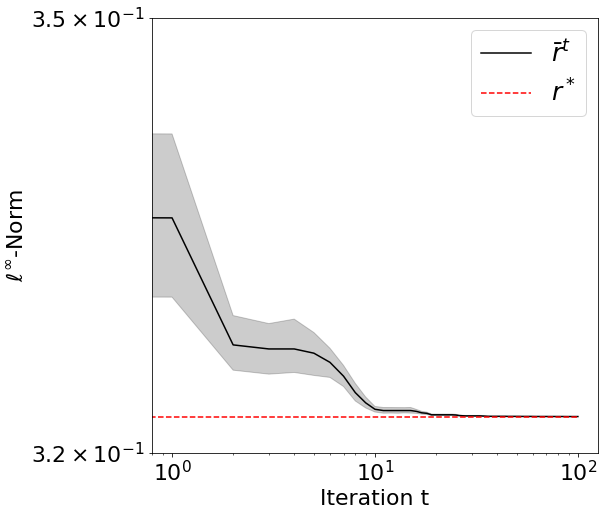

In [67]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (8,8))
# Set the scale of the x-and y-axes
ax.set(xscale="log", yscale="log")
sns.lineplot(data = pd_risks,x='iteration',y='max_risk',ax =ax,color = 'black',label = r'$\bar{r}^t$')
plt.plot(np.arange(101),np.ones([101])*np.max(risk_best),'r--',label = r'$r^*$')
plt.legend(fontsize = 25)
plt.xlabel('Iteration t', fontsize = 22)
plt.ylabel(r'$\ell^\infty$-Norm', fontsize = 22)
plt.ylim([0.32,0.35])
plt.xticks(fontsize = 22)
plt.yticks([0.32,0.35],fontsize = 22)
plt.show()

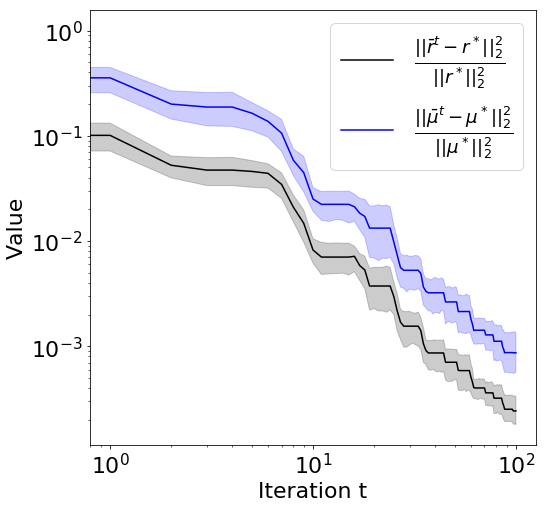

In [68]:
# Initialize figure and ax
fig, ax = plt.subplots(figsize = (8,8))
# Set the scale of the x-and y-axes
ax.set(xscale="log", yscale="log")
sns.lineplot(data = pd_risks,x='iteration',y='delta_risk',ax =ax,color = 'black',label = r'$\frac{||\bar{r}^t - r^*||_2^2}{||r^*||_2^2}$')
sns.lineplot(data = pd_risks,x='iteration',y='delta_mu',ax =ax,color = 'blue',label = r'$\frac{||\bar{\mu}^t - \mu^*||_2^2}{||\mu^*||_2^2}$')
plt.legend(fontsize = 26)
plt.xlabel('Iteration t', fontsize = 22)
plt.ylabel(r'Value', fontsize = 22)
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
# plt.xlim([0,500])
plt.show()

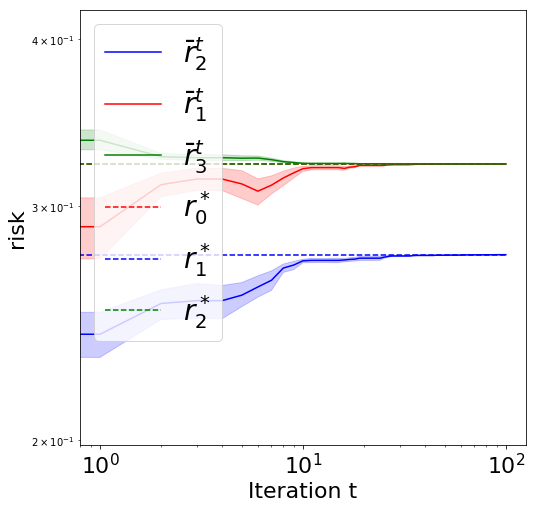

In [69]:
fig, ax = plt.subplots(figsize = (8,8))
# Set the scale of the x-and y-axes
ax.set(xscale="log", yscale="log")
sns.lineplot(data = pd_risks,x='iteration',y='risk1',ax =ax,color = 'blue',label = r'$\bar{r}^t_2$')
sns.lineplot(data = pd_risks,x='iteration',y='risk0',ax =ax,color = 'red',label = r'$\bar{r}^t_1$')
sns.lineplot(data = pd_risks,x='iteration',y='risk2',ax =ax,color = 'green',label = r'$\bar{r}^t_3$')
plt.plot(np.arange(101),np.ones([101])*risk_best[0],'r--',label = r'$r^*_{0}$')
plt.plot(np.arange(101),np.ones([101])*risk_best[1],'b--',label = r'$r^*_{1}$')
plt.plot(np.arange(101),np.ones([101])*risk_best[2],'g--',label = r'$r^*_{2}$')
plt.legend(fontsize = 28)
plt.xlabel('Iteration t', fontsize = 22)
plt.ylabel(r'risk', fontsize = 22)
plt.xticks(fontsize = 22)
plt.show()